In [2]:
import sys
if not '..' in sys.path:
    sys.path.append('..')
from analysis import collection, analysis, emg
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
import numpy as np
import seaborn as sns
import pandas as pd
import scipy as sp
from sklearn.decomposition import PCA, NMF
from sklearn.mixture import GaussianMixture
from joblib import dump, load
import json

%matplotlib inline
plt.style.use('ggplot')
mpl.rcParams.update({'axes.labelsize': 16})
mpl.rcParams.update({"figure.figsize": (15,9)})

image_path = Path("/Users/spencer/phd/phd/images/")

- online filtering is different from offline -- have functions for both
- we want to 
    - compare NMF components between two different calibration sessions to see how unique our decoder is
    - trace the operations to generate the decoder to make sure we know what we did

## Original NMF Decoder Approach

we L1-regularize the output (the projection of the data, W) to encourage the decoder to allow for single modes to be active at once. Ee can check this by looking at the correlation between the transformed data and seeking the least correlated projections.

$$WH   =  X$$

TxK x Kx64 = Tx64

transformation x components = data

factors x weights = data

inverse:

$$W = XH^{-1}$$
$$W^T = H^{-T}X^T$$

KxT = Kx64 x 64xT
We're not regularizing here, so the cost function for the fit looks like:

$$\min{||X - WH||^{2}_{loss}}$$

In [3]:
collection_name = "emg_olympics"
task_name = "center_hold"
c = collection.Collection(collection_name)
subjects = c.alphabetically_sorted_subjects()

In [4]:
decoders = []
decoder_residuals = []

In [5]:
def load_subject_calibration_stack(subject):
    stack = np.empty(shape=(2,32,64,24000))
    stack[:] = np.nan
    for session_idx, session_name in enumerate(["session_0", "session_1"]):
        filenames = analysis.get_calibration_emg_filenames(collection_name, subject.name, session_name)
        for bar_idx, filename in enumerate(filenames):
            e = analysis.load_calibration_emg(filename)
            stack[session_idx, bar_idx, :, :e.shape[0]] = e.T
    return np.array(stack)

def load_subject_calibration_bar_stack(subject):
    stack = np.empty(shape=(2,32,64,1000))
    stack[:] = np.nan
    for session_idx, session_name in enumerate(["session_0", "session_1"]):
        filenames = analysis.get_calibration_bar_filenames(collection_name, subject.name, session_name)
        for bar_idx, filename in enumerate(filenames):
            e = analysis.load_calibration_bar(filename)
            stack[session_idx, bar_idx, :, :e.shape[0]] = e.T
    return np.array(stack)

def generate_decoder(nmf_model, component_idxs, n_components):
    nmf_components = nmf_model.components_
    # factors = nmf_model.transform(filtered_calibration)

    # normalize the components
    norms = np.linalg.norm(nmf_components,axis=1).reshape(n_components,1)
    normalized_nmf_components = np.divide(nmf_components, norms)

    # invert the components
    inv_components = np.linalg.pinv(normalized_nmf_components).T

    # normalize the inverted components
    inv_norms = np.linalg.norm(inv_components,axis=1).reshape(n_components,1)
    normalized_inv_components = np.divide(inv_components, inv_norms)

    # make decoder (right,left,down,up) -- swap the order
    decoder = np.array(normalized_inv_components[component_idxs],dtype=np.float32)

    # convert to 2D  -- subtract right-left up-down)
    convert_to_2d = np.array([[1,-1,0,0],[0,0,-1,1]])
    two_dim_decoder = np.dot(convert_to_2d, decoder)

    return two_dim_decoder

In [6]:
for subject_idx in range(len(subjects)):
    subject_variance = subjects[subject_idx].variance
    subject_decoder = subjects[subject_idx].decoder[-2:,:]

    subject_calibration_stack = np.reshape(np.transpose(load_subject_calibration_stack(subjects[subject_idx]),axes=(0,2,1,3)),(2,64,-1))

    block_1 = analysis.remove_nan_rows(subject_calibration_stack[0].T)
    block_2 = analysis.remove_nan_rows(subject_calibration_stack[1].T)

    filtered_calibration_1 = emg.offline_filter_emg(block_1, subject_variance)
    filtered_calibration_2 = emg.offline_filter_emg(block_2, subject_variance)

    with open(f"/Users/spencer/motor-control/data/metadata/emg_olympics/{subjects[subject_idx].name}/metadata.json") as fp:
        component_idxs = json.load(fp)["components"]

    num_nmf_components = 4
    nmf_model_1 = NMF(n_components=num_nmf_components, max_iter=500, l1_ratio=0.9, random_state=0) # regularization="transformation"
    nmf_model_1.fit(filtered_calibration_1)

    nmf_model_2 = NMF(n_components=num_nmf_components, max_iter=500, l1_ratio=0.9, random_state=0) # regularization="transformation"
    nmf_model_2.fit(filtered_calibration_2)

    decoder_1 = generate_decoder(nmf_model_1,component_idxs=component_idxs,n_components=num_nmf_components)
    decoder_2 = generate_decoder(nmf_model_2,component_idxs=component_idxs,n_components=num_nmf_components)

    decoders.append((decoder_1,decoder_2))
    decoder_residuals.append((np.linalg.norm(subject_decoder-decoder_1),np.linalg.norm(subject_decoder-decoder_2)))

/opt/homebrew/Caskroom/miniconda/base/envs/scikit_0/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/opt/homebrew/Caskroom/miniconda/base/envs/scikit_0/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/opt/homebrew/Caskroom/miniconda/base/envs/scikit_0/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/opt/homebre

In [11]:
import pickle

with open('subject_decoders.pkl', 'wb') as handle:
    pickle.dump(decoders, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [15]:
with open('subject_decoders.pkl', 'rb') as handle:
    test_d = pickle.load(handle)
len(test_d)

46

In [7]:
decoder_residuals = []
dots = []
for (d1, d2), subject in zip(decoders, subjects):
    subject_decoder = subject.decoder[-2:,:]
    dots.append(np.dot(d1.reshape(-1),d2.reshape(-1)))
    decoder_residuals.append((np.linalg.norm(subject_decoder-d1),np.linalg.norm(subject_decoder-d2),np.linalg.norm(subject_decoder+d1),np.linalg.norm(subject_decoder+d2)))

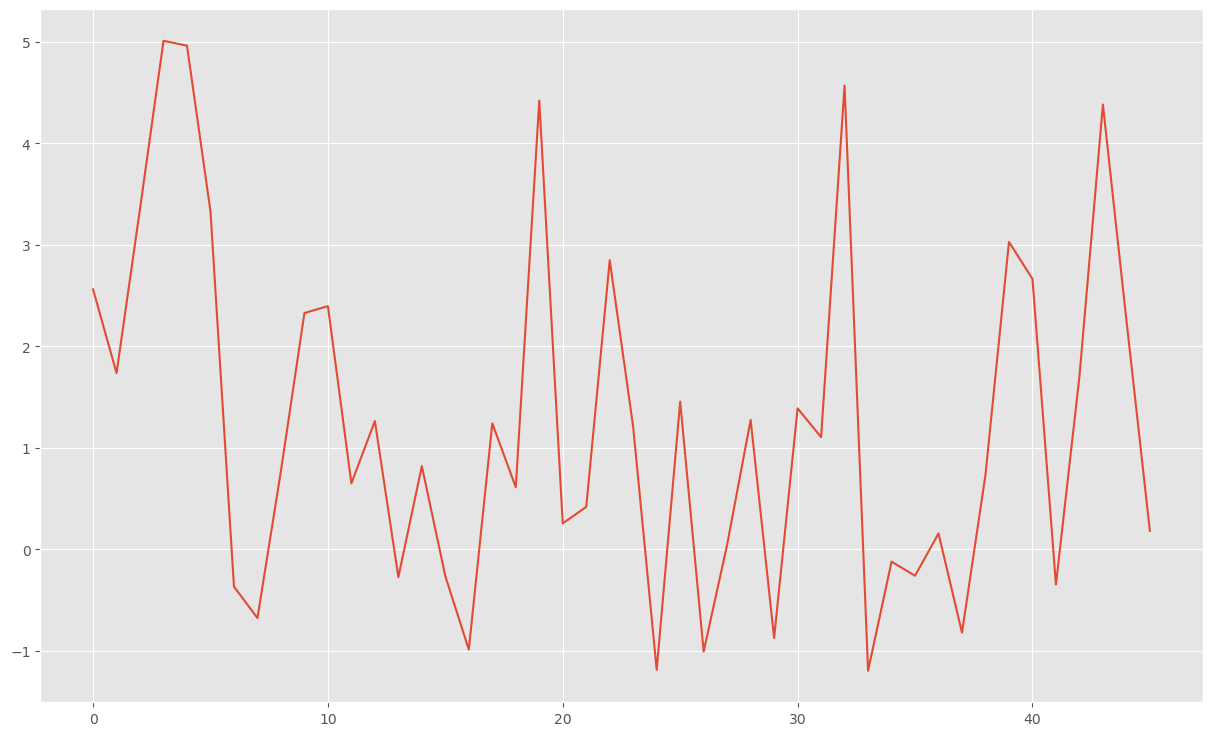

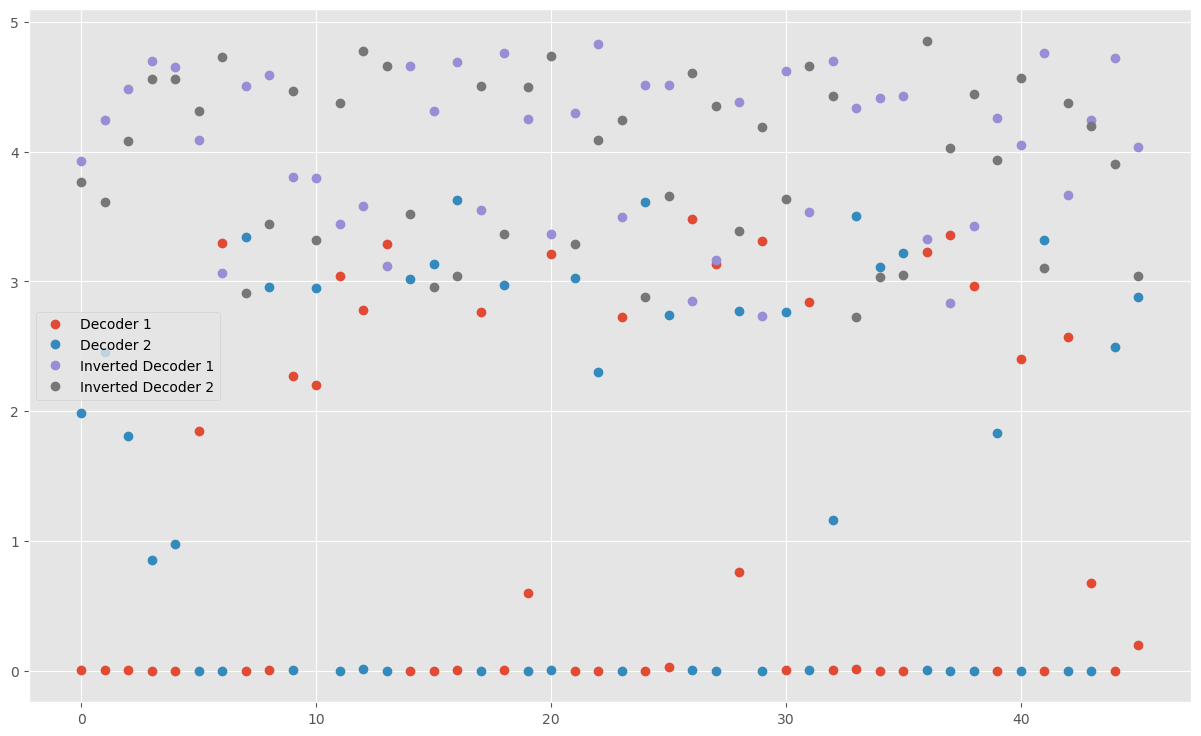

In [8]:
plt.plot(dots)

plt.figure()
plt.plot([dr[0] for dr in decoder_residuals],"o",label="Decoder 1")
plt.plot([dr[1] for dr in decoder_residuals],"o",label="Decoder 2")
plt.plot([dr[2] for dr in decoder_residuals],"o",label="Inverted Decoder 1")
plt.plot([dr[3] for dr in decoder_residuals],"o",label="Inverted Decoder 2")
plt.legend()

In [9]:
# plt.plot(emg.standardize(emg.offline_highpass(block_1, cutoff=5),subject_variance)[:40000,29])
# plt.plot(emg.standardize(emg.offline_highpass(block_2, cutoff=5),subject_variance)[:40000,29])
# plt.plot(filtered_calibration_1[:40000,29])
# plt.plot(filtered_calibration_2[:40000,29])
# plt.plot([0,40000],[0,0])

# plt.figure()
# plt.plot(np.diag(subject_variance**-1),label="Stored")
# plt.plot(np.std(block_1,axis=0),label="Calibration 1")
# plt.plot(np.std(block_2,axis=0),label="Calibration 2")
# plt.legend()

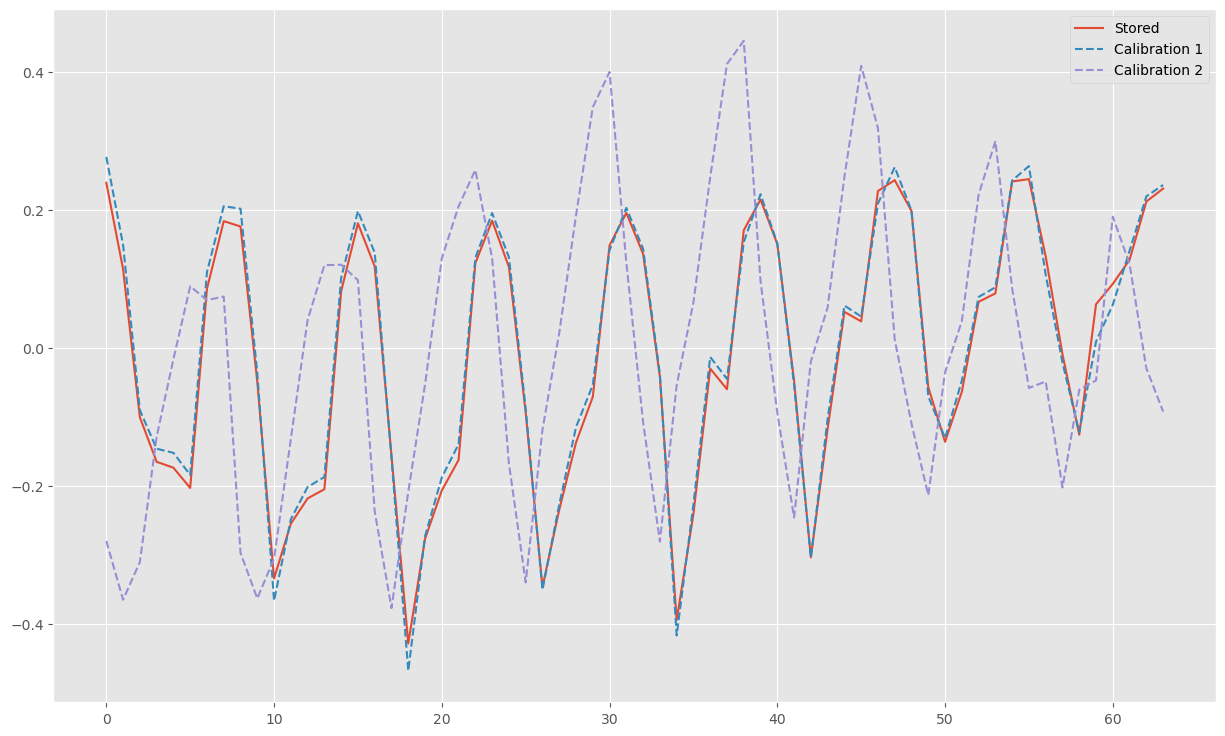

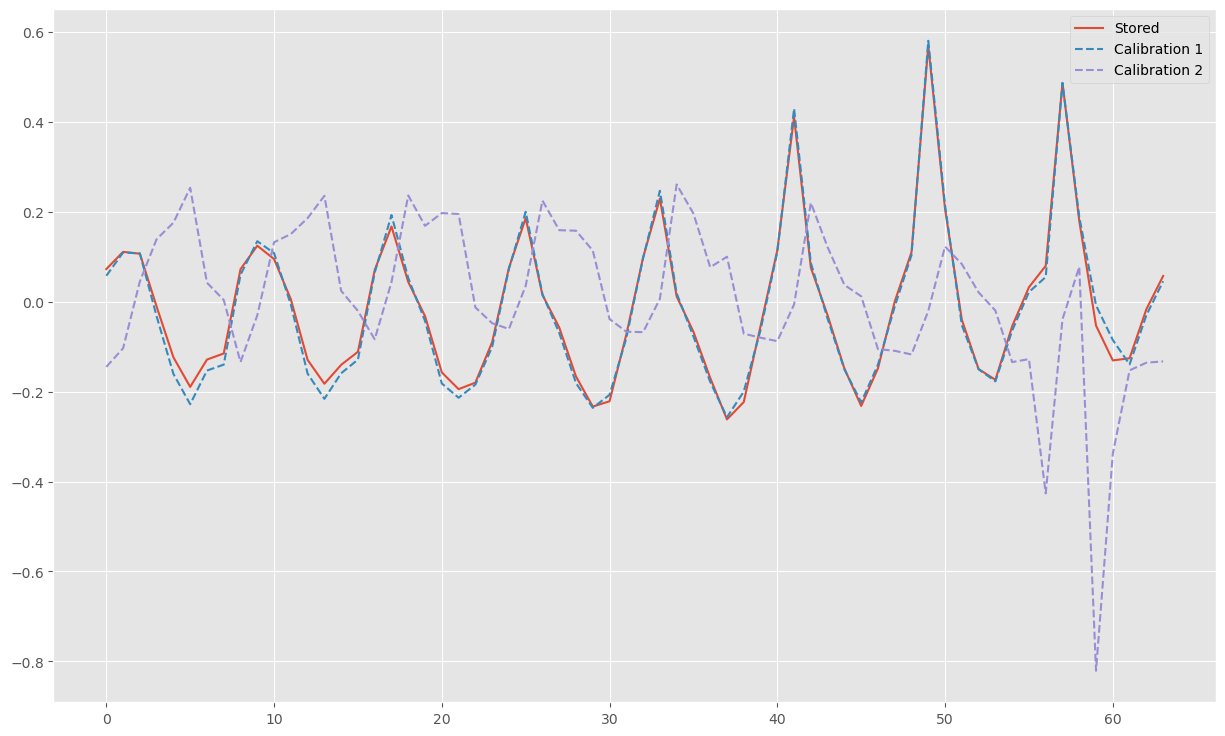

In [10]:
plt.figure()
plt.plot(subject_decoder[-2],label="Stored")
plt.plot(decoder_1[-2,:],"--",label="Calibration 1")
plt.plot(decoder_2[-2,:],"--",label="Calibration 2")
plt.legend()

plt.figure()
plt.plot(subject_decoder[-1],label="Stored")
plt.plot(decoder_1[-1,:],"--",label="Calibration 1")
plt.plot(decoder_2[-1,:],"--",label="Calibration 2")
plt.legend()